<a href="https://colab.research.google.com/github/EmiliaComputing/Machine-Learning/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and Install
*Will install libraries only if one of the libraries has not already been installed on the server, install commands are not written here.*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
from PIL import Image
import os
import gdown
import keras
import random
from zipfile import ZipFile

#Data

1. Unzip the data
2. Define the dataset
3. Get ready to display a random image from the dataset
4. Make a list with all the images in
5. Choose a random integer lower than 30,000
6. Display a random image from the datset using that integer

In [ ]:
def data():
    global dataset
    #Unzip
    with ZipFile("/content/celebA.zip", "r") as zip:
        zip.extractall("celebAgan")
    
    #Define dataset
    data_dir = "/content/celebAgan/celebA"
    print("FILES FOUND: ")
    dataset = keras.utils.image_dataset_from_directory(data_dir, label_mode=None, image_size=(64, 64), batch_size=32).map(lambda x: x / 255.0)


    #Get ready to display a random image from the dataset
    image_files = ([os.path.join(data_dir, f) 
    for f in os.listdir(data_dir)])

    #Make a list with all the images in and resize to make them smaller so that the programme runs faster
    images = []
    for file_path in image_files:
        img = Image.open(file_path).resize((64, 64))
        img_array = np.array(img) / 255.0
        images.append(img_array)

    #Choose a random integer between 0 and the length of the list with all the images in (x)
    x = random.randint(0, len(image_files))

    #Display value x of the list
    plt.grid(False)
    plt.axis("off")
    print("\nA RANDOM IMAGE FROM THE DATSET:")
    plt.imshow(mpimg.imread(image_files[x]))


FILES FOUND: 
Found 30000 files belonging to 1 classes.

A RANDOM IMAGE FROM THE DATSET:


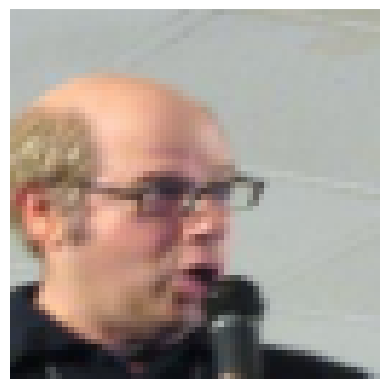

In [ ]:
#Run the code in the cell above
data()

#Create the Discriminator and the Generator

In [ ]:
def d():
  global discriminator
  discriminator = keras.Sequential(
      [
          keras.Input(shape=(64, 64, 3)),
          layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.3),
          layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.3),
          layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.3),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(1, activation="sigmoid"),
      ],
      name="discriminator",
  )
  discriminator.summary()

In [ ]:
latent_dim = 64

def g():
  global generator
  generator = keras.Sequential(
      [
          keras.Input(shape=(latent_dim,)),
          layers.Dense(8 * 8 * 128),
          layers.Reshape((8, 8, 128)),
          layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.8),
          layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.8),
          layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.8),
          layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
  generator.summary()

In [ ]:
print("DISCRIMINATOR SUMMARY")
d()
print("GENERATOR SUMMARY")
g()

DISCRIMINATOR SUMMARY
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (N

#Run

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images=dataset):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # add noise
        labels += random.randint(128, 1024)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points
        np.random.randn(49, self.latent_dim)

        # Assemble labels
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=8, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save("b_generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 500
  
global datset
global discriminator
global generator

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    #The learning rate is how much the model will change each time it gets it wrong
    #Optimising in computing is making features of it work more efficiently or using fewer resources
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=8, latent_dim=latent_dim)]
)

Epoch 1/500
353/938 [==========>...................] - ETA: 2:18 - d_loss: -452893671424.0000 - g_loss: 470830496.0000